## Technical Notebook - Intro to Scientific Computing 

### 2643977

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
from rasterio.mask import mask
import os

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Analysis Inputs

In [71]:
files_for_analysis = ['pre_tsunami', 'eight_days_post_tsunami', 'one_month_post_tsunami'] # these names must match folder names (max 3)

geojson_area_of_interest = geopandas.read_file("data/east_coast_map.geojson") # set to path for geojson file for area of analysis focus 

bands_of_interest = [1, 2, 3, 4]  # which bands are you interested in

bands_for_classification = [1, 2, 3, 4, 5, 6, 7]  # which bands to use for classification

In [3]:
def convert_to_reflectance(band):
    """
    Convert a band from digitized to reflectance. 
    Works for bands 1-7 only.
    """
    mult_parameter = 2.75e-05
    add_parameter = -0.2
    return band * mult_parameter + add_parameter

In [4]:
def preprocess_data(folder_name : str, area_of_interest : geopandas.GeoDataFrame, bands = [1, 2, 3, 4]):

    """ 
    Read in and preprocess raster data from a specified folder path.

    Parameters:
    folder_path (str): Path to the folder containing raster band files.
    area_of_interest (geopandas.GeoDataFrame): GeoDataFrame defining the area to crop the raster data.
    create_new (bool): Whether to create a new combined raster file. Defaults to True.
    new_file_name (str): Name for the new combined raster file. Required if create_new is True.
    bands (list): List of band numbers to process. Defaults to [1, 2, 3, 4].

    Returns:
    rasterio.DatasetReader: The combined raster data after preprocessing.
    """
    
    file_destination = "data/combined_rasters"
    band_number_str = str(len(bands))
    folder_path = os.path.join("data/", folder_name)
    new_file_name = f"{folder_name}_{band_number_str}_bands_processed.tif"
    new_file_path = os.path.join(file_destination, new_file_name)
    does_file_exist = os.path.exists(new_file_path)
    
    if not does_file_exist:

        band_data_combined = []
        for band in bands:
            band_substring = f"_B{band}"
            # find band file in folder
            band_file = [f for f in os.listdir(folder_path) if band_substring in f][0]
            band_path = os.path.join(folder_path, band_file)
            # read in band file
            with rasterio.open(band_path) as band_data:

                area_of_interest = area_of_interest.to_crs(band_data.crs)
                
                cropped_band_data, transform = mask(band_data, area_of_interest.geometry, crop=True)
                cropped_reflectance_band_data = convert_to_reflectance(cropped_band_data)
                band_data_combined.append(cropped_reflectance_band_data)

                meta = band_data.meta.copy()
                meta.update(
                    {                    
                        "transform": transform,
                        "height":cropped_reflectance_band_data.shape[1],
                        "width":cropped_reflectance_band_data.shape[2],
                        "count":len(bands),
                        "dtype": cropped_reflectance_band_data.dtype
                    }
                )

            print(f"Band {band} done")

        combined_bands_final = np.vstack(band_data_combined)

        with rasterio.open(new_file_path, "w", **meta) as dest:
            dest.write(combined_bands_final)

        combined_bands_final = rasterio.open(new_file_path)

    else:
        
        combined_bands_final = rasterio.open(new_file_path)

    return combined_bands_final

In [5]:
# running function to handle data, reading it in, processing, cropping and restoring it

dict_of_rasters = {}
for file_name in files_for_analysis:
    raster = preprocess_data(folder_name = file_name, area_of_interest = geojson_area_of_interest, bands = bands_of_interest)
    dict_of_rasters[file_name] = raster

In [ ]:
def visualise_r_g_b(dict_of_rasters: dict):

    """
    Plots RGB images for each raster in the dictionary.

    Parameters:
    dict_of_rasters (dict): Dictionary with raster names as keys and rasterio.DatasetReader objects as values.
    
    """

    number_of_rasters = len(dict_of_rasters)
    raster_counter = 0
    fig, axs = plt.subplots(number_of_rasters, 1, figsize=(10, 20))

    for key in dict_of_rasters:
        raster = dict_of_rasters[key]
        factor=3*np.mean(raster.read(3))
        rgb = np.dstack((raster.read(3),raster.read(2),raster.read(1)))/factor
        axs[raster_counter].imshow(rgb)
        axs[raster_counter].set_title(key.replace("_", " ").title())
        raster_counter += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8917630845862594..7.1439698058133105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1018297283622858..8.826826818268293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9233657204726546..7.397140497063965].


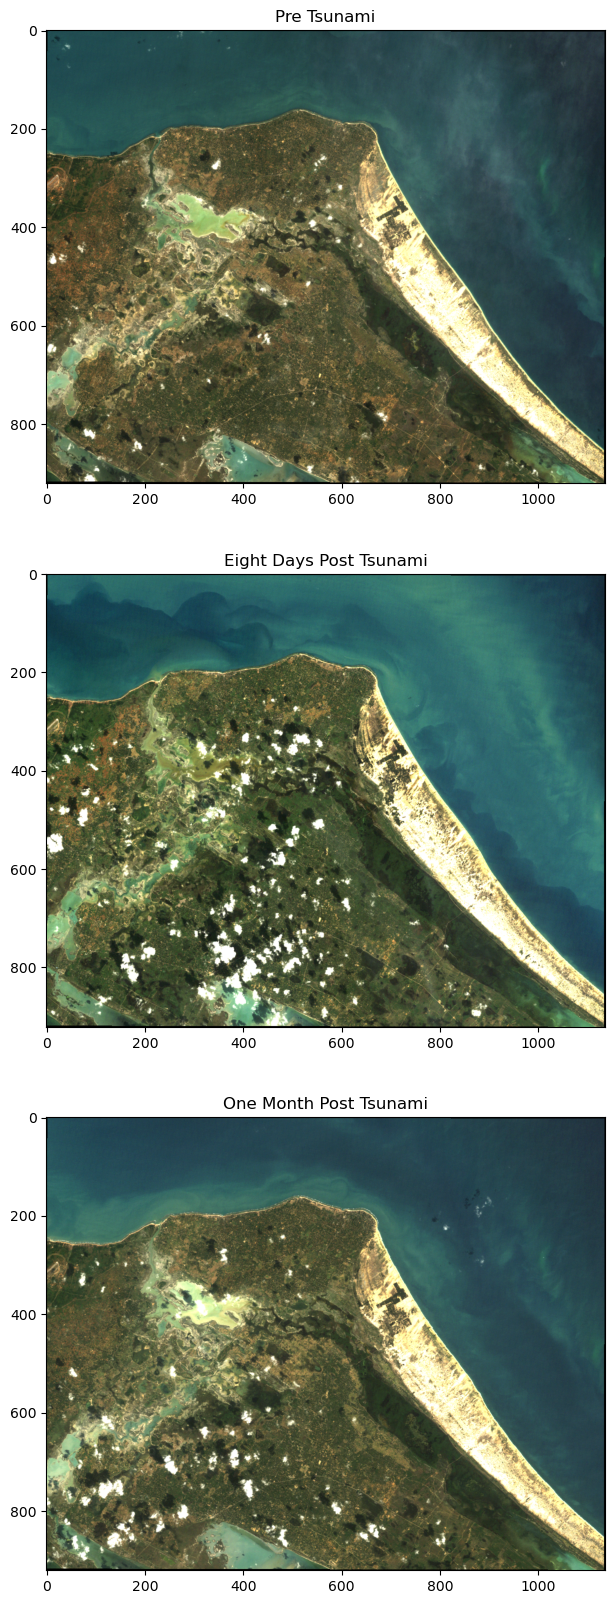

In [7]:
# compare red green blue of each image to visualise

visualise_r_g_b(dict_of_rasters)

In [59]:
# creating dictionary to allow easy transition between different band analysis

band_dict = {
    'blue' : 1,
    'green' : 2,
    'red' : 3,
    'nir' : 4,
    'swir' : 5,
    'thermal' : 6,
    'mir' : 7
}


In [ ]:
def plot_hist(dict_of_rasters: dict, band_one : str, band_two : str, colours = ['red', 'blue']):

    """
    Reads necessary bands and plots histograms for each raster in the dictionary.

    Parameters:
    dict_of_rasters (dict): Dictionary with raster names as keys and rasterio DatasetReader objects as values.
    band_one (str): Name of the first band to plot (e.g., 'red', 'green', 'blue').
    band_two (str): Name of the second band to plot (e.g., 'red', 'green', 'blue').
    colours (list): List of colours for the histograms. Defaults to ['red', 'blue'].
    
    """

    number_of_rasters = len(dict_of_rasters)
    raster_counter = 0
    fig, axs = plt.subplots(number_of_rasters, 1, figsize=(15, 15))
    band_1_num = band_dict[band_one.lower()]
    band_2_num = band_dict[band_two.lower()]

    for key in dict_of_rasters:
        raster = dict_of_rasters[key]
        band_1 = raster.read(band_1_num)
        band_2 = raster.read(band_2_num)
        labels = [band_one, band_two]
        for i, band in enumerate([band_1, band_2]):
            axs[raster_counter].hist(band.ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colours[i],label=labels[i],range=(0, band.max()))
        axs[raster_counter].set_title(f"{key.replace('_', ' ').title()} Histogram")
        axs[raster_counter].legend()
        raster_counter += 1

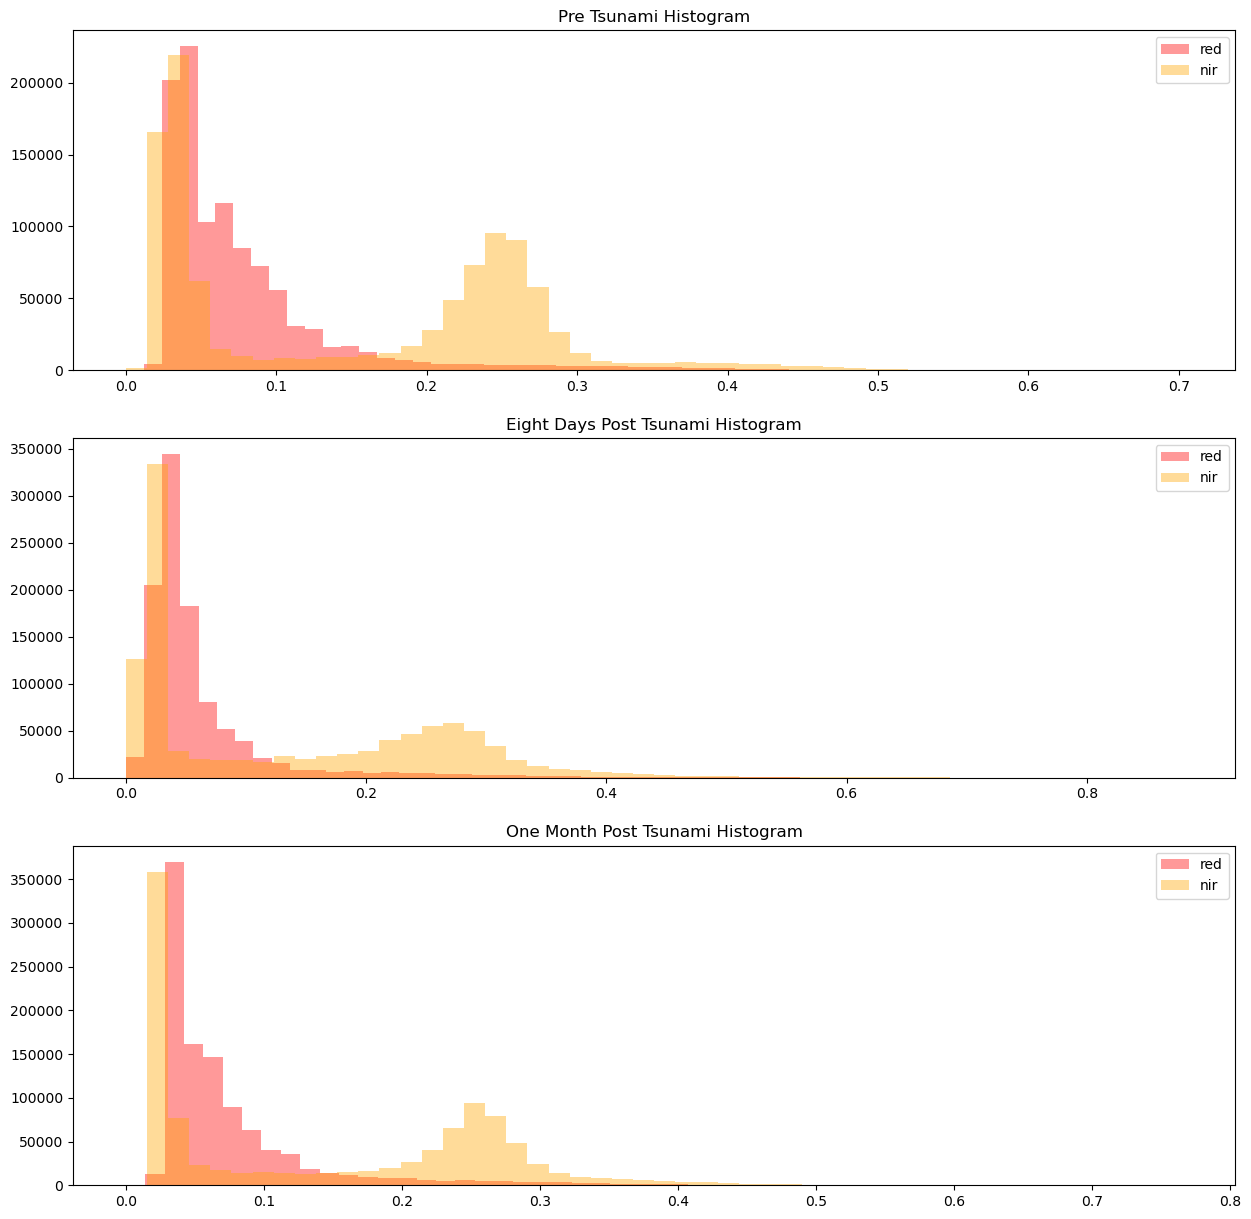

In [12]:
# create a histogram for each image showing break down of colour bands

plot_hist(dict_of_rasters, band_one = 'red', band_two = 'nir', colours=['red', 'orange'])

In [ ]:
def generate_index(dict_of_rasters: dict, index_name: str):

    """
    Generate specified index for each raster in the dictionary.
    
    Parameters:
    dict_of_rasters (dict): Dictionary with raster names as keys and rasterio.DatasetReader objects as values.
    index_name (str): Name of the index to generate ('ndvi', 'ndwi', 'msavi').

    Returns:
    dict: Dictionary with raster names as keys and index arrays as values.
    
    """

    index_dict = {}
    if index_name.lower() == 'ndvi':
        for key in dict_of_rasters:
            raster = dict_of_rasters[key]
            nir = raster.read(band_dict['nir'])
            red = raster.read(band_dict['red'])
            ndvi = (nir - red) / (nir + red)
            index_dict[key] = ndvi
    elif index_name.lower() == 'ndwi':
        for key in dict_of_rasters:
            raster = dict_of_rasters[key]
            green = raster.read(band_dict['green'])
            nir = raster.read(band_dict['nir'])
            ndwi = (green - nir) / (green + nir)
            index_dict[key] = ndwi
    elif index_name.lower() == 'msavi':
        for key in dict_of_rasters:
            raster = dict_of_rasters[key]
            nir = raster.read(band_dict['nir'])
            red = raster.read(band_dict['red'])
            msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
            index_dict[key] = msavi
    else:
        raise ValueError("Index not recognized. Please use 'ndvi', 'ndwi', or 'msavi'.")

    return index_dict

In [16]:
# generate ndvi 

ndvi_dict = generate_index(dict_of_rasters, 'ndvi')

In [ ]:
def visualise_index(index_dict: dict, index_name: str):

    """ 
    Visualise the specified index for each raster in the dictionary.

    Parameters:
    index_dict (dict): Dictionary with raster names as keys and index arrays as values.
    index_name (str): Name of the index being visualized (e.g., 'ndvi', 'ndwi', 'msavi').

    """

    number_of_indices = len(index_dict)
    index_counter = 0
    fig, axs = plt.subplots(number_of_indices, 1, figsize=(15, 15))

    index_cmap_dict = {
        'ndvi': 'PiYG',
        'ndwi': 'BrBG',
        'msavi': 'PuOr'
    }

    for key in index_dict:
        index_data = index_dict[key]
        im = axs[index_counter].imshow(index_data, cmap=index_cmap_dict[index_name.lower()], vmin=-1, vmax=1)
        axs[index_counter].set_title(f"{key.replace('_', ' ').title()} {index_name.upper()}")
        index_counter += 1

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=index_cmap_dict[index_name.lower()], norm=plt.Normalize(vmin=-1, vmax=1)),
                        ax=axs, orientation='vertical', fraction=0.05, pad=0.04, aspect = 35)
    cbar.set_label(index_name.upper())

    plt.show()

In [45]:
# plot ndvi

visualise_index(ndvi_dict, 'ndvi')

In [ ]:
coverage_df_list = []

def calculate_coverage(index_dict: dict, threshold: float, index_name: str):

    """
    Calculate the area and percentage of pixels in each index map that exceed a given threshold.

    Parameters:
    index_dict (dict): Dictionary where keys are time points and values are index arrays.
    threshold (float): Threshold value to determine coverage.
    index_name (str): Name of the index being analyzed.

    Returns:
    pd.DataFrame: DataFrame containing area and percentage coverage for each time point.

    """

    coverage_df = pd.DataFrame(columns=["Time", f"Area Covered by {index_name.upper()} > {threshold} (pixels)", f"Percentage Covered by {index_name.upper()} > {threshold} (%)"])

    for key in index_dict:
        index_data = index_dict[key]
        covered_area = np.sum(index_data > threshold)
        pct_covered = round(covered_area / index_data.size * 100, 3)
        new_row = [key.replace('_', ' ').title(), covered_area, pct_covered]
        coverage_df.loc[len(coverage_df)] = new_row

    coverage_df = coverage_df.set_index("Time")
    coverage_df_list.append(coverage_df)

    return coverage_df

In [67]:
# calculate area where ndvi > 0.5 for each image to critically assess change

ndvi_coverage_df = calculate_coverage(ndvi_dict, 0.5, 'ndvi')
ndvi_coverage_df

Area Covered by NDVI > 0.5 (pixels)  \
Time                                                           
Pre Tsunami                                           239743   
Eight Days Post Tsunami                               323616   
One Month Post Tsunami                                270381   

                         Percentage Covered by NDVI > 0.5 (%)  
Time                                                           
Pre Tsunami                                            22.935  
Eight Days Post Tsunami                                30.958  
One Month Post Tsunami                                 25.865

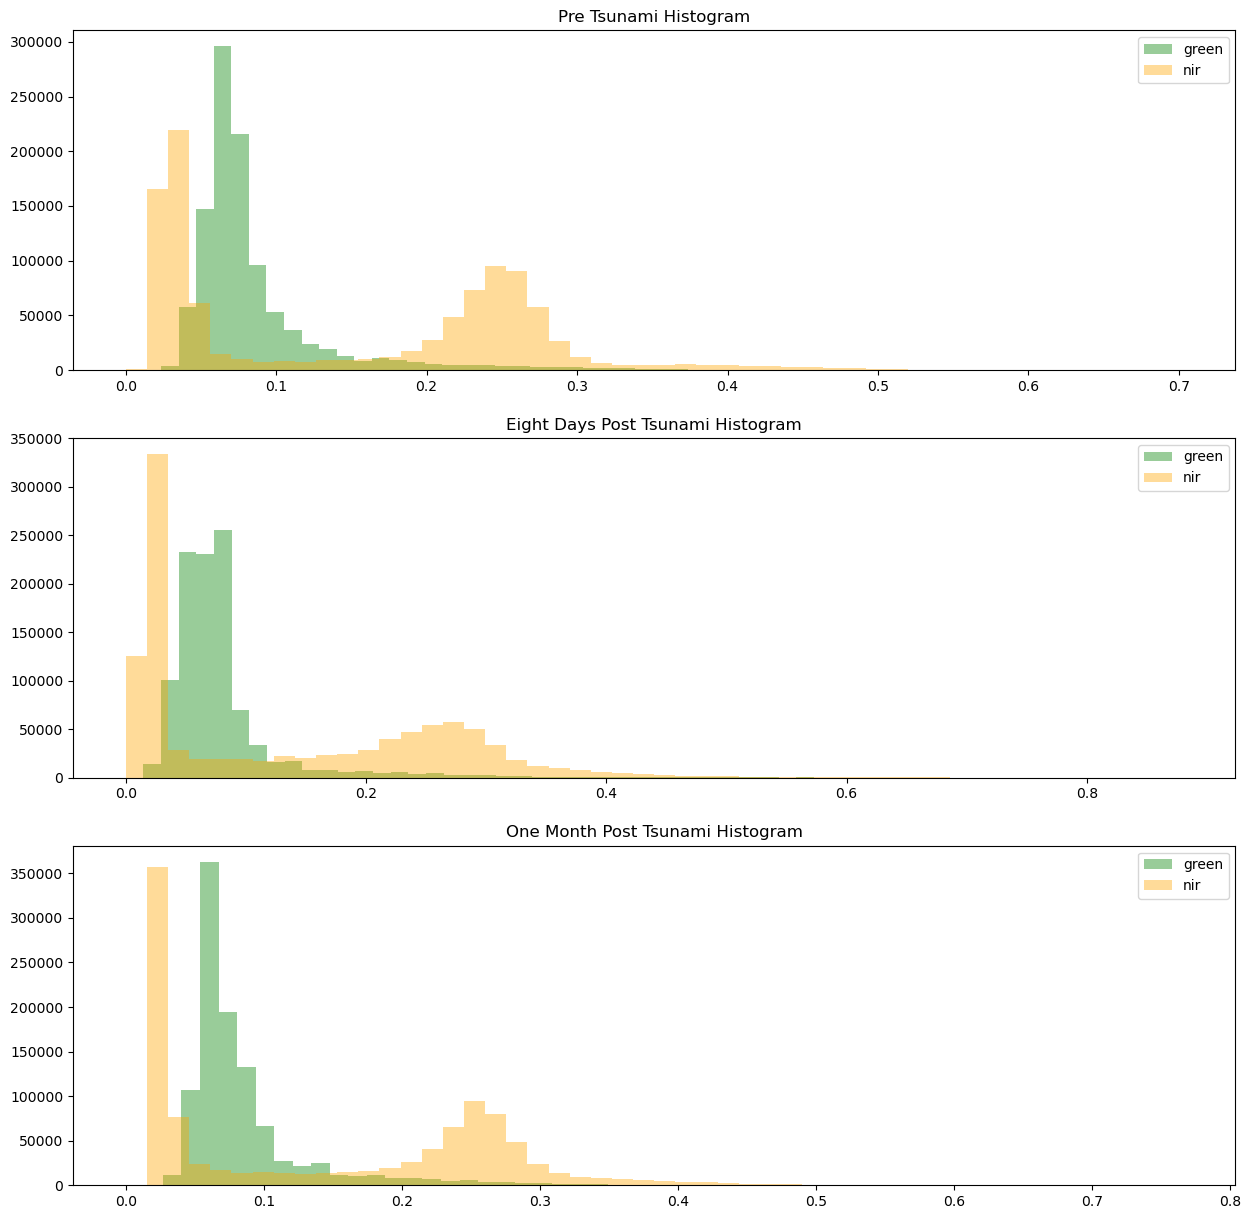

In [39]:
# create a histogram for each image showing break down of colour bands for ndwi

plot_hist(dict_of_rasters, band_one = 'green', band_two = 'nir', colours=['green', 'orange'])

In [40]:
# generate ndwi 

ndwi_dict = generate_index(dict_of_rasters, 'ndwi')

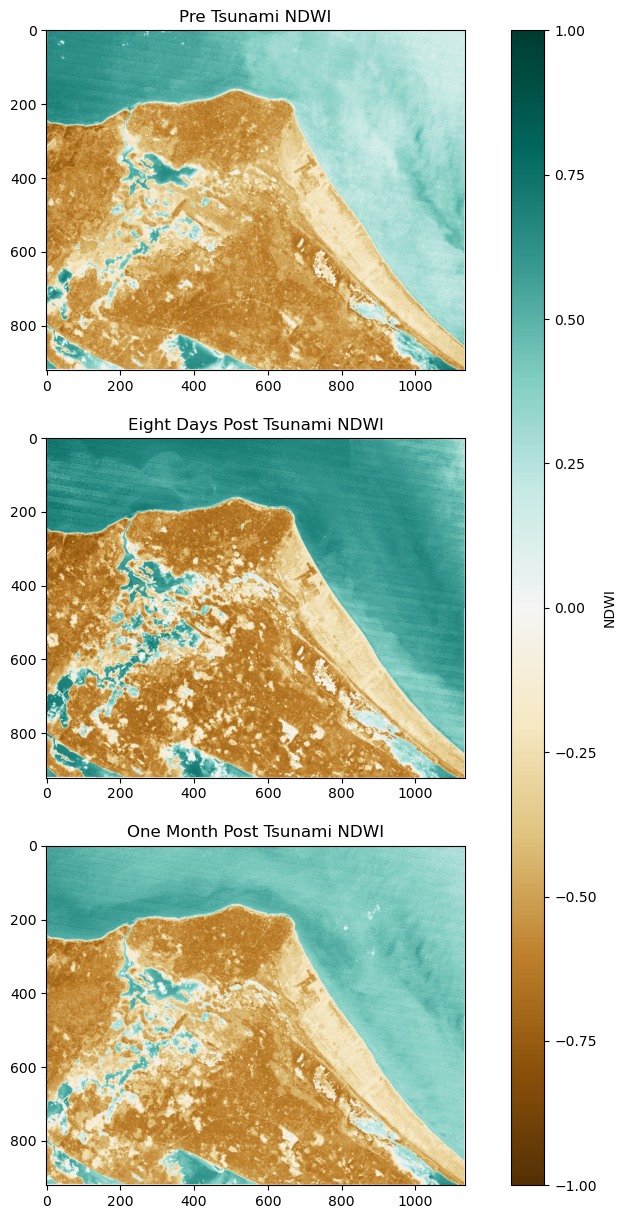

In [46]:
# plotting ndwi to visualise 

visualise_index(ndwi_dict, 'ndwi')

In [68]:
# calculate area where ndwi > 0.5 for each image

ndwi_coverage_df = calculate_coverage(ndwi_dict, 0.5, 'ndwi')
ndwi_coverage_df

Area Covered by NDWI > 0.5 (pixels)  \
Time                                                           
Pre Tsunami                                           111555   
Eight Days Post Tsunami                               373816   
One Month Post Tsunami                                 87812   

                         Percentage Covered by NDWI > 0.5 (%)  
Time                                                           
Pre Tsunami                                            10.672  
Eight Days Post Tsunami                                35.760  
One Month Post Tsunami                                  8.400

In [42]:
# generate msavi

msavi_dict = generate_index(dict_of_rasters, 'msavi')

In [47]:
# plt msavi to assess changes in soil moisture

visualise_index(msavi_dict, 'msavi')

In [69]:
# calculate area where msavi > 0.5 for each image

msavi_coverage_df = calculate_coverage(msavi_dict, 0.3, 'msavi')
msavi_coverage_df

Area Covered by MSAVI > 0.3 (pixels)  \
Time                                                            
Pre Tsunami                                            137968   
Eight Days Post Tsunami                                219590   
One Month Post Tsunami                                 181035   

                         Percentage Covered by MSAVI > 0.3 (%)  
Time                                                            
Pre Tsunami                                             13.198  
Eight Days Post Tsunami                                 21.007  
One Month Post Tsunami                                  17.318

In [70]:
# show combined index table
combined_index_df = pd.concat(coverage_df_list, axis=1, join = 'outer')

# drop area covered columns
columns_to_drop = [col for col in combined_index_df.columns if "Area Covered" in col]
combined_index_df = combined_index_df.drop(columns=columns_to_drop)

combined_index_df

Percentage Covered by NDVI > 0.5 (%)  \
Time                                                            
Pre Tsunami                                            22.935   
Eight Days Post Tsunami                                30.958   
One Month Post Tsunami                                 25.865   

                         Percentage Covered by NDWI > 0.5 (%)  \
Time                                                            
Pre Tsunami                                            10.672   
Eight Days Post Tsunami                                35.760   
One Month Post Tsunami                                  8.400   

                         Percentage Covered by MSAVI > 0.3 (%)  
Time                                                            
Pre Tsunami                                             13.198  
Eight Days Post Tsunami                                 21.007  
One Month Post Tsunami                                  17.318

In [72]:
# preparing data for classification

dict_of_classification_rasters = {}
for file_name in files_for_analysis:
    raster = preprocess_data(folder_name = file_name, area_of_interest = geojson_area_of_interest, bands = bands_for_classification)
    dict_of_classification_rasters[file_name] = raster

Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done


In [73]:
# necessary for runtime warning fix

LOKY_MAX_CPU_COUNT = 2

In [ ]:
def kmeans_classification(dict_of_classification_rasters: dict, n_clusters: int = 6, colour_map: list = ['darkgreen', 'green', 'navy', '#CA6F1E', 'black', 'forestgreen']):

    """
    Perform K-Means classification on raster data and plot the results.

    Parameters:
    dict_of_classification_rasters (dict): Dictionary where keys are raster names and values are rasterio.DatasetReader objects.
    n_clusters (int): Number of clusters for K-Means. Default is 6.
    colour_map (list): List of colors for the classification map. Default is ['darkgreen', 'green', 'navy', '#CA6F1E', 'black', 'forestgreen'].
    
    """

    for key in dict_of_classification_rasters:
        raster = dict_of_classification_rasters[key]

        # prep data 
        x = np.moveaxis(raster.read(), 0, -1)
        print(f"{key} shape: {x.shape}")
        height, width, bands = x.shape

        # normalise data
        x_data = x.reshape(-1, bands)
        scaler = StandardScaler().fit(x_data)
        x_scaled = scaler.transform(x_data)

        # kmeans classification
        kmeans_predictions = KMeans(n_clusters=n_clusters, random_state=2).fit(x_scaled)
        kmeans_predictions_2d = kmeans_predictions.labels_.reshape(height, width)

        # plot results
        plt.figure(figsize=(10, 8))
        cmap = ListedColormap(colour_map)
        plt.imshow(kmeans_predictions_2d, cmap=cmap)
        plt.colorbar(aspect=80)
        plt.title(f'Classification Map of K-Means - {key.replace("_", " ").title()}')
        plt.axis('off')
        plt.show()

pre_tsunami shape: (921, 1135, 7)


C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subproce

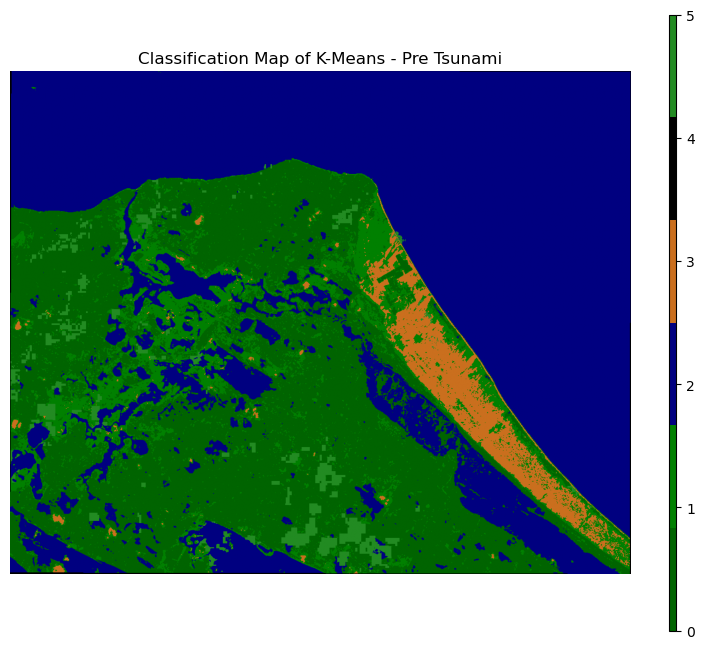

eight_days_post_tsunami shape: (921, 1135, 7)


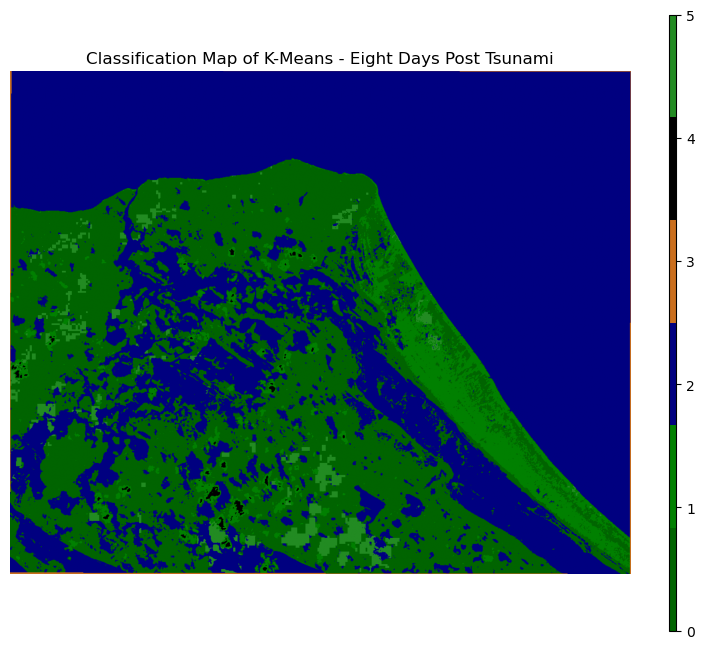

one_month_post_tsunami shape: (921, 1135, 7)


In [76]:
kmeans_classification(dict_of_classification_rasters, n_clusters=6)